<a href="https://colab.research.google.com/github/asyrofist/tugasKK/blob/master/Tugas_KK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download dataset Cardiotocography di UCI Machine Learning Repository dengan link URL https://archive.ics.uci.edu/ml/datasets/Cardiotocography


In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/asyrofist/tugasKK.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
/content/cloned-repo
CTG.xls  README.md


### Import Library

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools 

### Data Cleaning & Preprocessing

In [4]:
fn = r'/content/cloned-repo/CTG.xls'
xl = pd.ExcelFile(fn)
xl.sheet_names

for sh in xl.sheet_names:
  df = xl.parse(sh)
  print('Processing: [{}] ...'.format(sh))
  print(df.head())

Processing: [Description] ...
  Unnamed: 0  Unnamed: 1  ... Unnamed: 12                   Unnamed: 13
0        NaN         NaN  ...         NaN                           NaN
1        NaN         NaN  ...         NaN                           NaN
2  Worksheet         NaN  ...         NaN                           NaN
3        NaN         NaN  ...         NaN  DR is removed since p(K-W)=1
4        NaN         NaN  ...           p                           NaN

[5 rows x 14 columns]
Processing: [Data] ...
  Unnamed: 0 Unnamed: 1 Unnamed: 2  ...     22 Unnamed: 44   23
0          b          e         AC  ...  CLASS         NaN  NSP
1        240        357          0  ...      9         NaN    2
2          5        632          4  ...      6         NaN    1
3        177        779          2  ...      6         NaN    1
4        411       1192          2  ...      6         NaN    1

[5 rows x 46 columns]
Processing: [Raw Data] ...
       FileName       Date      SegFile      b  ...   FS  

In [0]:
dfs = {sh:xl.parse(sh) for sh in xl.sheet_names}
dfs.keys()
panjang = len(dfs['Raw Data'])
dfs['Raw Data'].head(panjang)

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,0.0,0.0,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,0.0,0.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,0.0,0.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2126,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,74.0,0.4,36.0,5.0,0.0,0.0,0.0,0.0,42.0,117.0,159.0,2.0,1.0,145.0,143.0,145.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2127,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Read the data into a Data Frame
df = pd.read_excel('/content/CTG.xls', sheet_name='Raw Data')

#remove the 3 lines indicating the total
df = df.dropna()

#remove irrelevant columns
df.drop(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'DR', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'], axis =1, inplace=True)
df = df.reset_index()
df.drop(['index'], axis =1, inplace=True)

df.to_csv('cleaned_data.csv', index=False)
df.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'CLASS', 'NSP'],
      dtype='object')

# 2. Lakukan proses normalisasi data jika datanya terdapat perbedaan skala (opsional)

In [0]:
#seperating the data into features and classes

#Features excluding CLASS and NSP
X = np.asarray(df[df.columns[:-2]]).astype(np.float32)
y_class = np.asarray(df.CLASS).astype(np.int32)
y_nsp = np.asarray(df.NSP).astype(np.int32)

#Features including CLASS
X_with_class = np.asarray(df[df.columns[:-1]]).astype(np.float32)

#Features including NSP
col = ['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency','NSP']
temp = df[col]
X_with_nsp = np.asarray(temp).astype(np.float32)

#Splitting the data into training and test sets. 4 different sets are created.

#Spliting for the first group. X features excludes both CLASS and NSP and the label being predicted is CLASS
#for set 1
X_train1, X_test1, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, shuffle= True, random_state = 0)

#splitting for the 2nd group. X features excludes both CLASS and NSP and the label being predicted is NSP
#for set 2
X_train2, X_test2, y_nsp_train, y_nsp_test = train_test_split(X, y_nsp, test_size=0.2, shuffle= True, random_state = 0)


#splitting for the 3rd group. X features includes both CLASS and the label being predicted is NSP
#for set 3
X_train3, X_test3, y_nsp_train3, y_nsp_test3 = train_test_split(X_with_class, y_nsp, test_size=0.2, shuffle= True, random_state = 0)

#splitting for the 4th group. X features includes both NSP and the label being predicted is CLASS
#for set 4
X_train4, X_test4, y_class_train4, y_class_test4 = train_test_split(X_with_nsp, y_class, test_size=0.2, shuffle= True, random_state = 0)

### Data Exploration

<function matplotlib.pyplot.show>

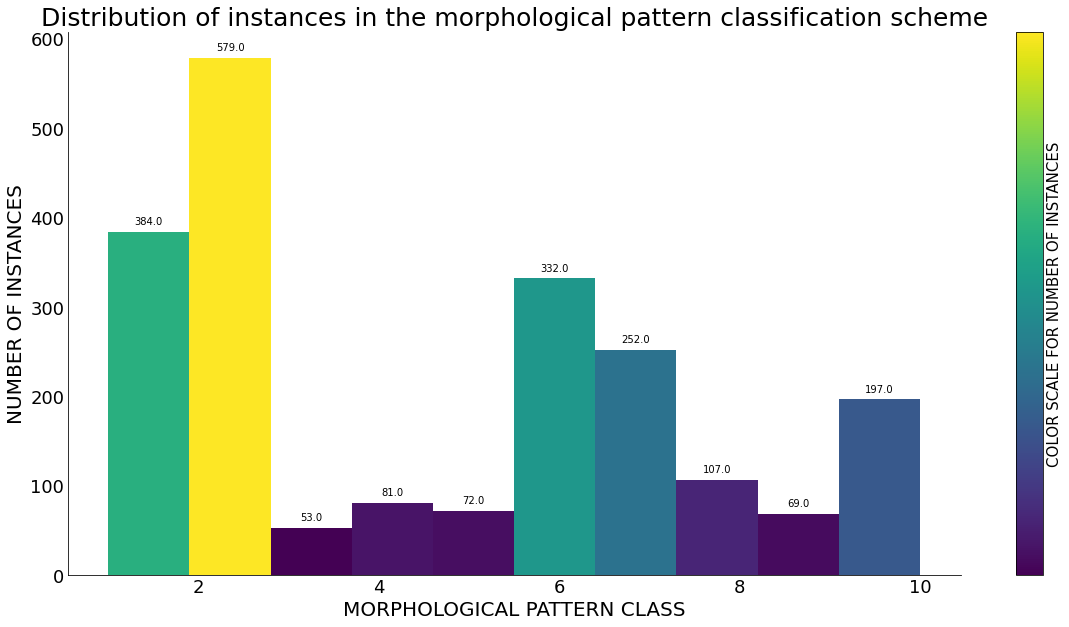

In [0]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
%matplotlib inline


#PLOT HISTOGRAM SHOWING THE DISTRIBUTION OF CLASSES WITHIN THE 10 CLASS
plt.figure(figsize=(20,10))
N, bins, patches= plt.hist(y_class, bins =10)
    
# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)    
plt.xlabel('MORPHOLOGICAL PATTERN CLASS', fontsize = 20)
plt.ylabel('NUMBER OF INSTANCES', fontsize = 20)
plt.title('Distribution of instances in the morphological pattern classification scheme', fontsize = 25)

ax = plt.gca()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=18)

cm = plt.cm.get_cmap('viridis')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[])
cbar.set_label('COLOR SCALE FOR NUMBER OF INSTANCES', fontsize=15)


plt.savefig("image_class.png")
    
plt.show

<function matplotlib.pyplot.show>

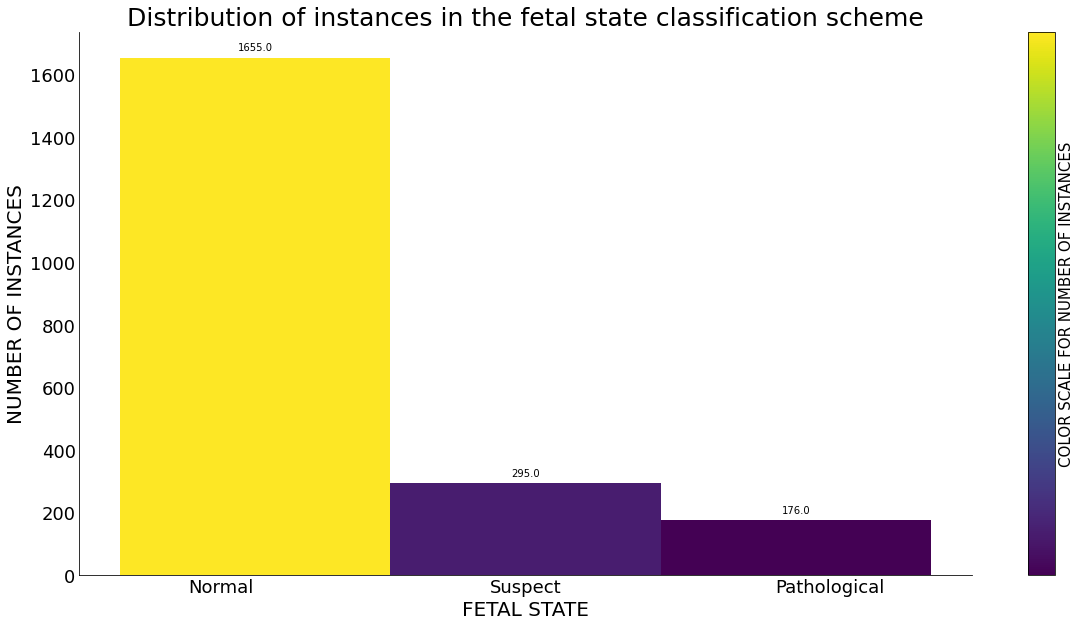

In [0]:
#PLOT HISTOGRAM SHOWING THE DISTRIBUTION OF CLASSES WITHIN THE 3 CLASSES (NSP)

plt.figure(figsize=(20,10))
N, bins, patches= plt.hist(y_nsp, bins =3)
    
# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)    
plt.xlabel('FETAL STATE', fontsize=20)
plt.ylabel('NUMBER OF INSTANCES', fontsize=20)
plt.title('Distribution of instances in the fetal state classification scheme', fontsize = 25)

ax = plt.gca()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)


    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)


a=['','','Normal','','','Suspect','','','Pathological','']
ax.set_xticklabels(a)
ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=18)

cm = plt.cm.get_cmap('viridis')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[])
cbar.set_label('COLOR SCALE FOR NUMBER OF INSTANCES', fontsize=15)

plt.savefig("image_nsp.png")
    
plt.show

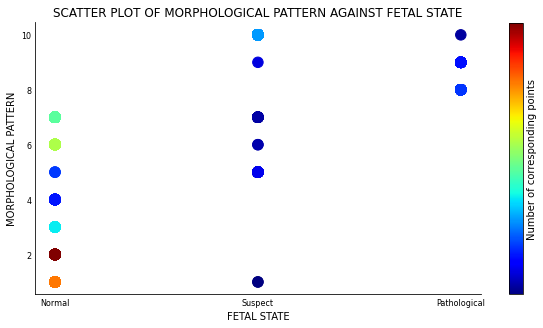

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm

plt.figure(figsize=(10,5))
samples = np.array([y_nsp,y_class])
densObj = kde( samples )

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

colours = makeColours( densObj.evaluate( samples ) )
cm = plt.cm.get_cmap('jet')

ax = plt.gca()

sc = ax.scatter( samples[0], samples[1], color=colours, s=110)

plt.xlabel("FETAL STATE")
plt.ylabel('MORPHOLOGICAL PATTERN')
plt.title('SCATTER PLOT OF MORPHOLOGICAL PATTERN AGAINST FETAL STATE')


ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

b=['','Normal','','','','Suspect','','','','Pathological']
ax.set_xticklabels(b)
ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=8)

cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[])
cbar.ax.set_yticklabels(['','','','','',''])  # horizontal colorbar
cbar.set_label('Number of corresponding points')

plt.savefig("correlation.png")

# 3. Lakukan proses Reduksi Dimensi menggunakan PCA atau LDA pada dataset yang sudah ternormalisasi

### Program Principal Component Analysis (PCA)

In [0]:
#import numpy dan matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#membuat fungsi PCA
def pca(input, dimensi):
    (n, d) = input.shape
    #centering (mengurangi dg nilai mean by row datanya)
    mean_data = np.mean(input, 0)#mean data by row
    mean_data_n = np.tile(mean_data, (n, 1))#diulang sebanyak rownya
    input = input - mean_data_n#dikurangkan dengan data ori
    
    #PCA dilakukan dengan eigen decomposition dari matriks kovarians
    matriks_kovarians = np.dot(input.T, input)/n
    (lamda, v) = np.linalg.eig(matriks_kovarians)
    
    #matriks proyeksi adalah n-eigenvector (v)
    #dg n-eigenvalue (lamda) terbesar,
    matriks_proyeksi = v[:, 0:dimensi]
    
    #data input diproyeksikan dengan cara dikalikan (dot product)
    #dengan matriks proyeksi
    Y = np.dot(input, matriks_proyeksi)
    
    #print matriks kovarians, eigenvalue dan eigenvector
    #untuk keperluan pembalajaran saja
    print("mean: ", mean_data)
    print("matriks kovarians: ", matriks_kovarians)
    print("eigenvalue: ", lamda)
    print("eigenvector: ", v)
    
    #mengembalikan nilai data hasil proyeksi (Y)
    return Y

In [0]:
#data fitur dari file asli
data_ori = X_train1

In [0]:
#memproyeksikan data ori tetap ke dua dimensi
data_terproyeksi_3dimensi = pca(data_ori,3)

mean:  [1.3331824e+02 2.7276471e+00 6.8011765e+00 3.6494117e+00 4.7045296e+01
 1.3220013e+00 9.8029413e+00 8.2467089e+00 1.5641177e+00 2.9411765e-03
 1.1941177e-01 7.0478233e+01 9.3648827e+01 1.6412706e+02 4.0641174e+00
 3.2117647e-01 1.3765118e+02 1.3474471e+02 1.3828177e+02 1.8585882e+01
 3.2941177e-01]
matriks kovarians:  [[ 9.4778015e+01 -3.0203881e+00 -1.3718493e+01 -2.9290185e+00
   5.1404408e+01 -2.3631775e+00  4.9213886e+01 -1.4723334e+00
  -3.7959936e+00 -2.9759495e-02 -4.9153045e-01 -5.5749237e+01
   1.0283057e+02  4.7081318e+01 -3.4862869e+00  1.0731264e-02
   1.1114161e+02  1.0816123e+02  1.0957269e+02 -3.8351738e+01
   1.6892871e+00]
 [-3.0203881e+00  1.2872272e+01  5.7064486e+00  2.4039280e+00
  -1.1572957e+01  6.1252111e-01 -2.2630148e+01 -2.9040442e+00
   4.8149647e-03 -6.8460261e-03 -1.6688950e-01  3.9476715e+01
  -1.6513287e+01  2.2963432e+01  2.0527563e+00 -7.2329110e-03
   1.2106765e+01  1.2666946e+01  1.2427330e+01  1.1876040e+01
   9.2657320e-02]
 [-1.3718493e+01 

In [0]:
#memproyeksikan data ori tetap ke dua dimensi
data_terproyeksi_2dimensi = pca(data_ori,2)

mean:  [1.3331824e+02 2.7276471e+00 6.8011765e+00 3.6494117e+00 4.7045296e+01
 1.3220013e+00 9.8029413e+00 8.2467089e+00 1.5641177e+00 2.9411765e-03
 1.1941177e-01 7.0478233e+01 9.3648827e+01 1.6412706e+02 4.0641174e+00
 3.2117647e-01 1.3765118e+02 1.3474471e+02 1.3828177e+02 1.8585882e+01
 3.2941177e-01]
matriks kovarians:  [[ 9.4778015e+01 -3.0203881e+00 -1.3718493e+01 -2.9290185e+00
   5.1404408e+01 -2.3631775e+00  4.9213886e+01 -1.4723334e+00
  -3.7959936e+00 -2.9759495e-02 -4.9153045e-01 -5.5749237e+01
   1.0283057e+02  4.7081318e+01 -3.4862869e+00  1.0731264e-02
   1.1114161e+02  1.0816123e+02  1.0957269e+02 -3.8351738e+01
   1.6892871e+00]
 [-3.0203881e+00  1.2872272e+01  5.7064486e+00  2.4039280e+00
  -1.1572957e+01  6.1252111e-01 -2.2630148e+01 -2.9040442e+00
   4.8149647e-03 -6.8460261e-03 -1.6688950e-01  3.9476715e+01
  -1.6513287e+01  2.2963432e+01  2.0527563e+00 -7.2329110e-03
   1.2106765e+01  1.2666946e+01  1.2427330e+01  1.1876040e+01
   9.2657320e-02]
 [-1.3718493e+01 

In [0]:
#mengurangi/memproyeksikan data ori ke 1 dimensi
data_terproyeksi_1dimensi = pca(data_ori,1)

mean:  [1.3331824e+02 2.7276471e+00 6.8011765e+00 3.6494117e+00 4.7045296e+01
 1.3220013e+00 9.8029413e+00 8.2467089e+00 1.5641177e+00 2.9411765e-03
 1.1941177e-01 7.0478233e+01 9.3648827e+01 1.6412706e+02 4.0641174e+00
 3.2117647e-01 1.3765118e+02 1.3474471e+02 1.3828177e+02 1.8585882e+01
 3.2941177e-01]
matriks kovarians:  [[ 9.4778015e+01 -3.0203881e+00 -1.3718493e+01 -2.9290185e+00
   5.1404408e+01 -2.3631775e+00  4.9213886e+01 -1.4723334e+00
  -3.7959936e+00 -2.9759495e-02 -4.9153045e-01 -5.5749237e+01
   1.0283057e+02  4.7081318e+01 -3.4862869e+00  1.0731264e-02
   1.1114161e+02  1.0816123e+02  1.0957269e+02 -3.8351738e+01
   1.6892871e+00]
 [-3.0203881e+00  1.2872272e+01  5.7064486e+00  2.4039280e+00
  -1.1572957e+01  6.1252111e-01 -2.2630148e+01 -2.9040442e+00
   4.8149647e-03 -6.8460261e-03 -1.6688950e-01  3.9476715e+01
  -1.6513287e+01  2.2963432e+01  2.0527563e+00 -7.2329110e-03
   1.2106765e+01  1.2666946e+01  1.2427330e+01  1.1876040e+01
   9.2657320e-02]
 [-1.3718493e+01 

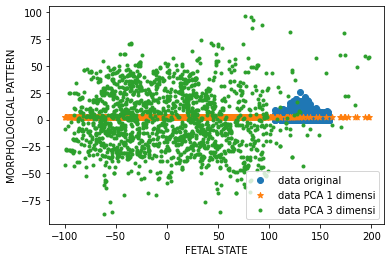

In [0]:
#mengeplot data
plt.scatter(data_ori[:,0], data_ori[:,1], marker="o", label="data original")
axis_1D = np.tile(2,(data_ori.shape[0])) #aksis dg 1 nilai konstant untuk
                                         #keperluan visualisasi saja
plt.scatter(data_terproyeksi_1dimensi, axis_1D,
            marker="*", label="data PCA 1 dimensi")
# plt.scatter(data_terproyeksi_2dimensi[:,0], data_terproyeksi_2dimensi[:,1],
#             marker="^", label="data PCA 2 dimensi")
plt.scatter(data_terproyeksi_3dimensi[:,0], data_terproyeksi_3dimensi[:,2],
            marker=".", label="data PCA 3 dimensi")
plt.xlabel("FETAL STATE")
plt.ylabel("MORPHOLOGICAL PATTERN")
plt.legend()
plt.show()

### Latent Dirichlet allocation (LDA)

In [0]:
#mengimport numpy, pytlab, intertools dan scikit-learn
import numpy as np
import pylab
import itertools
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
p=2 #ukuran dimensi tujuan

#membaca dataset MNIST dari file
X = X_train1
labels = y_nsp_train

In [0]:
#mendefinisikan LDA
clf = LinearDiscriminantAnalysis(n_components=2)
clf.fit(X, labels)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [0]:
#mentransform data asli ke data tertransformasi menggunakan LDA
Y=clf.transform(X)

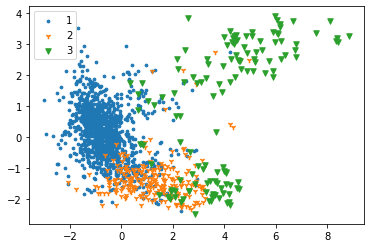

In [0]:
#mengeplot data tertransformasi
marker = itertools.cycle(('.','1','v', '^', '<','>','s','2','+','x'))
for label in np.unique(labels):
    pylab.scatter(np.ravel(Y[labels == label, 0]),
                  np.ravel(Y[labels == label, 1]),
                  label=label, s=30, marker=marker.__next__())
pylab.legend()
pylab.show()

### 4. Lakukan proses Seleksi fitur menggunakan salah satu metode pada dataset yang sudah ternormalisasi

In [0]:
data_scaler = StandardScaler()

X_train1 = data_scaler.fit_transform(X_train1)
X_train2 = data_scaler.fit_transform(X_train2)
X_train3 = data_scaler.fit_transform(X_train3)
X_train4 = data_scaler.fit_transform(X_train4)

X_test1 = data_scaler.fit_transform(X_test1)
X_test2 = data_scaler.fit_transform(X_test2)
X_test3 = data_scaler.fit_transform(X_test3)
X_test4 = data_scaler.fit_transform(X_test4)

In [0]:
print("Training X1", X_train1)
print("Training X2", X_train2)
print("Training X3", X_train3)
print("Training X4", X_train4)
print("\n")
print("Test X1", X_test1)
print("Test X2", X_test2)
print("Test X3", X_test3)
print("Test X4", X_test4)

Training X1 [[-0.23812415  2.0269685  -0.1928861  ...  0.40271613  0.11890966
   1.1019766 ]
 [-1.2653027   0.07591089 -0.1928861  ... -0.8649635   0.22339612
   1.1019766 ]
 [ 1.5080793   0.35463336 -0.1928861  ...  1.388689   -0.5428378
  -0.5413219 ]
 ...
 [-0.44355986  0.07591089 -0.1645254  ... -0.09027039 -0.40352252
  -0.5413219 ]
 [-0.5462777   0.07591089 -0.1928861  ... -0.16069703  0.25822493
   1.1019766 ]
 [-1.9843276  -0.7602566  -0.1928861  ... -1.5692298  -0.6473242
  -0.5413219 ]]
Training X2 [[-0.23812415  2.0269685  -0.1928861  ...  0.40271613  0.11890966
   1.1019766 ]
 [-1.2653027   0.07591089 -0.1928861  ... -0.8649635   0.22339612
   1.1019766 ]
 [ 1.5080793   0.35463336 -0.1928861  ...  1.388689   -0.5428378
  -0.5413219 ]
 ...
 [-0.44355986  0.07591089 -0.1645254  ... -0.09027039 -0.40352252
  -0.5413219 ]
 [-0.5462777   0.07591089 -0.1928861  ... -0.16069703  0.25822493
   1.1019766 ]
 [-1.9843276  -0.7602566  -0.1928861  ... -1.5692298  -0.6473242
  -0.5413219

# 5. Lakukan proses klasifikasi menggunakan metode SVM pada dataset yang dgn fitur lengkap, dgn fitur yg sdh direduksi, dan dgn fitur yg sudah dilakukan seleksi.

### Support Vector Machine versi 1

In [0]:
# Creating a SVM classifier instance
svc = SVC()

#Calling the scaler
data_scaler = StandardScaler()

model = make_pipeline(data_scaler, svc)
param_grid = {'svc__C': [ 20, 30, 50, 100, 125, 150, 200],
              'svc__gamma': [ 0.01, 0.015, 0.02, 0.05]}


#Grid search for the best parameters while doing 5-fold cross validation
grid1 = GridSearchCV(model, param_grid, cv=5)
grid1.fit(X_train1, y_class_train)

grid2 = GridSearchCV(model,param_grid, cv=5)
grid2.fit(X_train2, y_nsp_train)

grid3 = GridSearchCV(model,param_grid, cv=5)
grid3.fit(X_train3, y_nsp_train3)

grid4 = GridSearchCV(model,param_grid, cv=5)
grid4.fit(X_train4, y_class_train4)
print( grid4.best_estimator_)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=20, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.015, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [0]:
# Selecting the best estimator after the parameter search
print(grid1.best_estimator_)
print(grid2.best_estimator_)
print(grid3.best_estimator_)
print(grid4.best_estimator_)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=200, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=30, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.05, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     ver

In [0]:
grid1.cv_results_['mean_test_score']

array([0.83882353, 0.84470588, 0.84705882, 0.85294118, 0.84294118,
       0.84705882, 0.84470588, 0.85352941, 0.84411765, 0.84882353,
       0.85294118, 0.85352941, 0.85      , 0.85647059, 0.85176471,
       0.84588235, 0.85764706, 0.85588235, 0.84941176, 0.84352941,
       0.85647059, 0.85176471, 0.84941176, 0.84588235, 0.85823529,
       0.85294118, 0.84941176, 0.84352941])

### Plotting Confusion Matrix

In [0]:
# This function let you draw a confusion matrix for your problem

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    #print(cm)
    
    plt.figure()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
# Predicting the test labels
y_pred1 = grid1.predict(X_test1)
y_pred2 = grid2.predict(X_test2)
y_pred3 = grid3.predict(X_test3)
y_pred4 = grid4.predict(X_test4)

In [0]:
from sklearn.model_selection import cross_val_score
cv1_svm = cross_val_score(grid1, X_train1, y_class_train, cv=5)
cv2_svm = cross_val_score(grid2, X_train2, y_nsp_train, cv=5)
cv3_svm = cross_val_score(grid3, X_train3, y_nsp_train3, cv=5)
cv4_svm = cross_val_score(grid4, X_train4, y_class_train4, cv=5)

In [0]:
print('cross validation for model 1: ', cv1_svm)
print('cross validation for model 2: ', cv2_svm)
print('cross validation for model 3: ', cv3_svm)
print('cross validation for model 4: ', cv4_svm)

cross validation for model 1:  [0.88823529 0.84117647 0.85882353 0.83529412 0.81764706]
cross validation for model 2:  [0.92647059 0.94117647 0.93235294 0.91470588 0.9       ]
cross validation for model 3:  [0.97647059 0.97647059 0.96176471 0.96176471 0.97058824]
cross validation for model 4:  [0.92941176 0.90294118 0.9        0.91764706 0.87941176]


In [0]:
rata2_svm1 = np.array(cv1_svm).mean()
rata2_svm2 = np.array(cv2_svm).mean()
rata2_svm3 = np.array(cv3_svm).mean()
rata2_svm4 = np.array(cv4_svm).mean()
print("rata2 SVM1", rata2_svm1)
print("rata2 SVM2", rata2_svm2)
print("rata2 SVM3", rata2_svm3)
print("rata2 SVM4", rata2_svm3)

rata2 SVM1 0.8482352941176471
rata2 SVM2 0.9229411764705882
rata2 SVM3 0.9694117647058823
rata2 SVM4 0.9694117647058823


              precision    recall  f1-score   support

           1       0.82      0.86      0.84        78
           2       0.91      0.93      0.92       114
           3       0.57      0.57      0.57         7
           4       0.84      0.94      0.89        17
           5       0.86      0.67      0.75        18
           6       0.84      0.86      0.85        63
           7       0.92      0.81      0.86        54
           8       0.92      0.92      0.92        25
           9       0.92      0.65      0.76        17
          10       0.72      0.85      0.78        33

    accuracy                           0.86       426
   macro avg       0.83      0.81      0.81       426
weighted avg       0.86      0.86      0.86       426

              precision    recall  f1-score   support

      normal       0.95      0.96      0.96       326
     suspect       0.77      0.76      0.77        58
pathological       0.92      0.86      0.89        42

    accuracy           

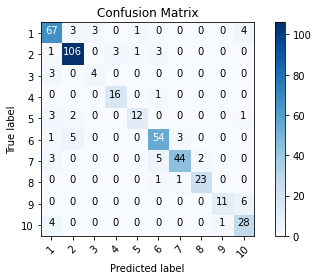

In [0]:
# Printing the classification report
target_names = ['normal', 'suspect', 'pathological']

print(classification_report(y_pred=y_pred1,y_true=y_class_test))
print(classification_report(y_pred=y_pred2,y_true=y_nsp_test,target_names=target_names))
print(classification_report(y_pred=y_pred3,y_true=y_nsp_test3,target_names=target_names))
print(classification_report(y_pred=y_pred4,y_true=y_class_test4))

confusion_mtx1 = confusion_matrix(y_class_test, y_pred1)
confusion_mtx2 = confusion_matrix(y_nsp_test, y_pred2)
confusion_mtx3 = confusion_matrix(y_nsp_test3, y_pred3)
confusion_mtx4 = confusion_matrix(y_class_test4, y_pred4)


print("model 1 accuracy= ",(confusion_mtx1.diagonal().sum()/confusion_mtx1.sum())*100)
print("model 2 accuracy= ",(confusion_mtx2.diagonal().sum()/confusion_mtx2.sum())*100)
print("model 3 accuracy= ",(confusion_mtx3.diagonal().sum()/confusion_mtx3.sum())*100)
print("model 4 accuracy= ",(confusion_mtx4.diagonal().sum()/confusion_mtx4.sum())*100)

plot_confusion_matrix(confusion_mtx1, ['1','2','3','4','5','6','7','8','9','10'])

### SVM versi 2
For the SVM classifier, I experimented with the various available kernels, the penalty of the error term and the tolerance for stopping criteria. The following values of the parameters attained the best accuracy during classification. Results in the table below.
1. Kernel: rbf (Marginally outperformed 'linear, 'poly' and 'sigmoid' kernels.)
2. C, penalty of the error term: 1 (Best amongst 0.1, 0.5, 1 and 10)
3. Tolerance for stopping criteria: 1e-3 (Best amongst 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)

              precision    recall  f1-score   support

           1       0.97      0.84      0.90        91
           2       0.89      0.90      0.90       113
           3       0.29      0.50      0.36         4
           4       0.59      1.00      0.74        10
           5       0.67      0.92      0.77        13
           6       0.84      0.79      0.82        67
           7       0.76      0.85      0.80        48
           8       0.96      1.00      0.98        24
           9       1.00      1.00      1.00        17
          10       1.00      0.85      0.92        39

    accuracy                           0.87       426
   macro avg       0.80      0.87      0.82       426
weighted avg       0.89      0.87      0.87       426

              precision    recall  f1-score   support

           1       0.88      0.85      0.87        81
           2       0.95      0.93      0.94       116
           3       0.43      0.50      0.46         6
           4       0.76 

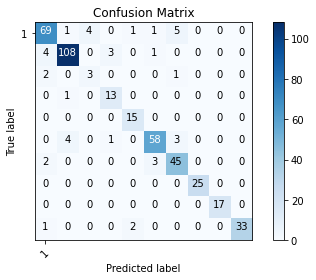

In [0]:
from sklearn import svm

# rbf kernal
svm_clf_rbf = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3)
svm_clf_rbf.fit(X_train4, y_class_train4)
svm_clf_rbf_pred = svm_clf_rbf.predict(X_test4)
SVM_rbf = classification_report(y_pred=y_class_test4,y_true=svm_clf_rbf_pred)
print(SVM_rbf)

# Linear kernel
svm_clf_linear = svm.SVC(kernel = 'linear')
svm_clf_linear.fit(X_train4, y_class_train4)
svm_clf_linear_pred = svm_clf_linear.predict(X_test4)
SVM_linear = classification_report(y_pred=y_class_test4,y_true=svm_clf_linear_pred)
print(SVM_linear)

# Poly kernal
svm_clf_poly = svm.SVC(kernel = 'poly')
svm_clf_poly.fit(X_train4, y_class_train4)
svm_clf_poly_pred = svm_clf_poly.predict(X_test4)
SVM_poly = classification_report(y_pred=y_class_test4,y_true=svm_clf_poly_pred)
print(SVM_poly)

# Singmoid kernel
svm_clf_sigmoid = svm.SVC(kernel = 'sigmoid')
svm_clf_sigmoid.fit(X_train4, y_class_train4)
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(X_test4)
SVM_sigmoid = classification_report(y_pred=y_class_test4,y_true=y_class_test4)
print(SVM_sigmoid)

confusion_rbf = confusion_matrix(svm_clf_rbf_pred, y_class_test4)
confusion_linear = confusion_matrix(svm_clf_linear_pred, y_class_test4)
confusion_poly = confusion_matrix(svm_clf_poly_pred, y_class_test4)
confusion_sigmoid = confusion_matrix(svm_clf_sigmoid_pred, y_class_test4)

hasil_rbf     = (confusion_rbf.diagonal().sum()/confusion_mtx1.sum())*100
hasil_linear  = (confusion_linear.diagonal().sum()/confusion_mtx2.sum())*100
hasil_poly    = (confusion_mtx3.diagonal().sum()/confusion_mtx3.sum())*100
hasil_sigmoid = (confusion_sigmoid.diagonal().sum()/confusion_mtx4.sum())*100

print("model rbf kernel accuracy= ",hasil_rbf)
print("model linear kernel accuracy= ",hasil_linear)
print("model poly kernel accuracy= ",hasil_poly)
print("model sigmoid kernel accuracy= ",hasil_sigmoid)

plot_confusion_matrix(confusion_linear, ['1'])

### Artificial Neural Network - Multilayer Perceptron Classifier versi 1

In [0]:
def mlp(Xtrain, ytrain, Xtest, ytest):
    from sklearn.neural_network import MLPClassifier
    
    #create an MLP with 4 hidden layer having 30 neurons
    mlp_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,30,30,30), max_iter=500, alpha=0.0001, batch_size=8,
                     solver='adam', verbose=1,  random_state=22, tol=0.00000000000000000001, validation_fraction=0.15, early_stopping=True, n_iter_no_change=100)
    mlp_clf.fit(Xtrain, ytrain)
    ypred = mlp_clf.predict(Xtest)
    
    #cv_acc = cross_val_score(mlp_clf, Xtrain, ytrain, cv=5 )
    cv_acc = 0
    confusion_mtx = confusion_matrix(ytest, ypred)
    plot_confusion_matrix(confusion_mtx, [str(i) for i in range(1,len(confusion_mtx)+1)])
    accuracy = (confusion_mtx.diagonal().sum()/confusion_mtx.sum())*100
    return print(classification_report(y_pred = ypred, y_true = ytest),'\n', 'cross validation accuracy =', cv_acc, '\n', 'test accuracy =', accuracy)

Iteration 1, loss = 1.86739354
Validation score: 0.639216
Iteration 2, loss = 0.93547940
Validation score: 0.788235
Iteration 3, loss = 0.60276369
Validation score: 0.807843
Iteration 4, loss = 0.46348839
Validation score: 0.839216
Iteration 5, loss = 0.38696718
Validation score: 0.854902
Iteration 6, loss = 0.33187070
Validation score: 0.862745
Iteration 7, loss = 0.29636820
Validation score: 0.866667
Iteration 8, loss = 0.26868603
Validation score: 0.874510
Iteration 9, loss = 0.25568036
Validation score: 0.886275
Iteration 10, loss = 0.24129187
Validation score: 0.866667
Iteration 11, loss = 0.22362928
Validation score: 0.874510
Iteration 12, loss = 0.21431209
Validation score: 0.901961
Iteration 13, loss = 0.19282597
Validation score: 0.890196
Iteration 14, loss = 0.18371307
Validation score: 0.894118
Iteration 15, loss = 0.17262337
Validation score: 0.890196
Iteration 16, loss = 0.17539212
Validation score: 0.878431
Iteration 17, loss = 0.17325164
Validation score: 0.874510
Iterat

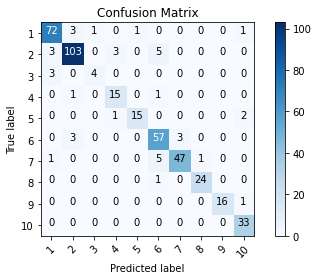

In [0]:
mlp(X_train4, y_class_train4, X_test4, y_class_test4)

Iteration 1, loss = 1.84948922
Validation score: 0.627451
Iteration 2, loss = 1.04008464
Validation score: 0.698039
Iteration 3, loss = 0.74930299
Validation score: 0.737255
Iteration 4, loss = 0.61745890
Validation score: 0.737255
Iteration 5, loss = 0.54272632
Validation score: 0.792157
Iteration 6, loss = 0.49154079
Validation score: 0.811765
Iteration 7, loss = 0.44913658
Validation score: 0.800000
Iteration 8, loss = 0.42698407
Validation score: 0.815686
Iteration 9, loss = 0.39749735
Validation score: 0.815686
Iteration 10, loss = 0.38632532
Validation score: 0.827451
Iteration 11, loss = 0.36340260
Validation score: 0.843137
Iteration 12, loss = 0.34341987
Validation score: 0.827451
Iteration 13, loss = 0.32901362
Validation score: 0.811765
Iteration 14, loss = 0.32133364
Validation score: 0.815686
Iteration 15, loss = 0.29712285
Validation score: 0.815686
Iteration 16, loss = 0.28911674
Validation score: 0.827451
Iteration 17, loss = 0.28496156
Validation score: 0.843137
Iterat

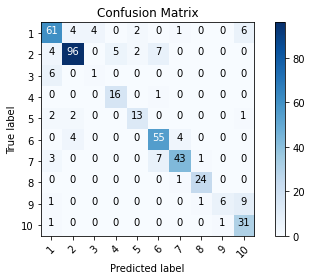

In [0]:
mlp(X_train1, y_class_train, X_test1, y_class_test)

Iteration 1, loss = 0.52194936
Validation score: 0.858824
Iteration 2, loss = 0.30869478
Validation score: 0.894118
Iteration 3, loss = 0.24593353
Validation score: 0.898039
Iteration 4, loss = 0.21797872
Validation score: 0.890196
Iteration 5, loss = 0.20103915
Validation score: 0.898039
Iteration 6, loss = 0.19862712
Validation score: 0.917647
Iteration 7, loss = 0.17822246
Validation score: 0.901961
Iteration 8, loss = 0.16772710
Validation score: 0.905882
Iteration 9, loss = 0.16324256
Validation score: 0.921569
Iteration 10, loss = 0.14984474
Validation score: 0.917647
Iteration 11, loss = 0.14342020
Validation score: 0.898039
Iteration 12, loss = 0.13298677
Validation score: 0.913725
Iteration 13, loss = 0.12488846
Validation score: 0.925490
Iteration 14, loss = 0.11778631
Validation score: 0.886275
Iteration 15, loss = 0.12570160
Validation score: 0.909804
Iteration 16, loss = 0.10539467
Validation score: 0.901961
Iteration 17, loss = 0.10353831
Validation score: 0.913725
Iterat

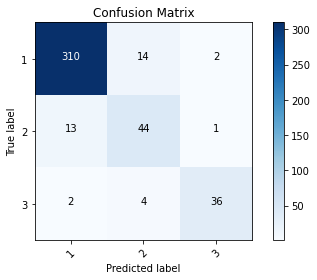

In [0]:
mlp(X_train2, y_nsp_train, X_test2, y_nsp_test)

Iteration 1, loss = 0.43901409
Validation score: 0.933333
Iteration 2, loss = 0.18527542
Validation score: 0.960784
Iteration 3, loss = 0.13043135
Validation score: 0.952941
Iteration 4, loss = 0.10002566
Validation score: 0.960784
Iteration 5, loss = 0.08485968
Validation score: 0.952941
Iteration 6, loss = 0.06702088
Validation score: 0.952941
Iteration 7, loss = 0.05112301
Validation score: 0.964706
Iteration 8, loss = 0.05639715
Validation score: 0.960784
Iteration 9, loss = 0.04520726
Validation score: 0.952941
Iteration 10, loss = 0.03894001
Validation score: 0.964706
Iteration 11, loss = 0.03432049
Validation score: 0.960784
Iteration 12, loss = 0.03420086
Validation score: 0.956863
Iteration 13, loss = 0.03894677
Validation score: 0.956863
Iteration 14, loss = 0.03176917
Validation score: 0.960784
Iteration 15, loss = 0.02993205
Validation score: 0.964706
Iteration 16, loss = 0.02582348
Validation score: 0.972549
Iteration 17, loss = 0.02733479
Validation score: 0.968627
Iterat

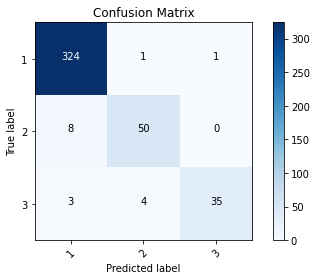

In [0]:
mlp(X_train3, y_nsp_train3, X_test3, y_nsp_test3)

### Artificial Neural Network versi 2
For the ANN classifier, I experimented with the activation function, the solver for weight optimization, regularization term and learning schedule for weight updates. The following values of the parameters attained the best accuracy during classification. Other parameters were neither applicable to the 'adam' solver nor did it improve the performance of the model. Results in the table below.
1. Activation: Logistic (Marginally outperformed 'relu', 'tanh' and 'identity' functions.)
2. Solver: Adam (Works well on relatively large datasets with thousands of training samples or more)
3. Alpha: 1e-4 (Best amongst 1, 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)
4. Learning Rate: 'invscaling' (Gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'.)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.91      0.91      0.91        78
           2       0.90      0.90      0.90       114
           3       0.00      0.00      0.00         7
           4       0.57      0.71      0.63        17
           5       0.92      0.67      0.77        18
           6       0.87      0.94      0.90        63
           7       0.94      0.89      0.91        54
           8       0.96      0.92      0.94        25
           9       0.92      0.71      0.80        17
          10       0.77      1.00      0.87        33

    accuracy                           0.88       426
   macro avg       0.78      0.76      0.76       426
weighted avg       0.87      0.88      0.87       426



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.81      0.92      0.86        78
           2       0.78      0.95      0.86       114
           3       0.00      0.00      0.00         7
           4       1.00      0.06      0.11        17
           5       0.00      0.00      0.00        18
           6       0.45      0.84      0.58        63
           7       0.78      0.26      0.39        54
           8       0.00      0.00      0.00        25
           9       0.00      0.00      0.00        17
          10       0.54      1.00      0.70        33

    accuracy                           0.66       426
   macro avg       0.44      0.40      0.35       426
weighted avg       0.60      0.66      0.58       426



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.03      0.01      0.02        78
           2       0.50      0.98      0.67       114
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        18
           6       0.35      0.86      0.49        63
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        25
           9       0.00      0.00      0.00        17
          10       0.58      0.33      0.42        33

    accuracy                           0.42       426
   macro avg       0.15      0.22      0.16       426
weighted avg       0.24      0.42      0.29       426



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.84      0.95      0.89        78
           2       0.86      0.94      0.90       114
           3       0.00      0.00      0.00         7
           4       0.75      0.18      0.29        17
           5       1.00      0.11      0.20        18
           6       0.83      0.90      0.86        63
           7       0.88      0.80      0.83        54
           8       0.93      1.00      0.96        25
           9       0.81      0.76      0.79        17
          10       0.70      0.97      0.81        33

    accuracy                           0.84       426
   macro avg       0.76      0.66      0.65       426
weighted avg       0.83      0.84      0.81       426

model TanH accuracy=  87.55868544600939
model Relu accuracy=  65.96244131455398
model Log accuracy=  41.78403755868544
model Identity accuracy=  83.56807511737088



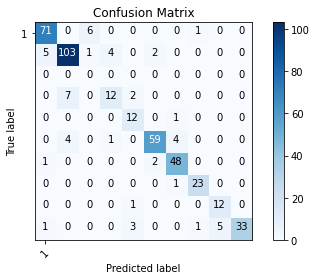

In [0]:
from sklearn.neural_network import MLPClassifier

# Tan H
ann_tanh = MLPClassifier(activation = 'tanh', solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(10, 2), random_state=1, warm_start=True)
ann_tanh.fit(X_train4, y_class_train4)                         
ann_tanh_pred = ann_tanh.predict(X_test4)
ANN_TanH = classification_report(y_true= y_class_test4, y_pred=ann_tanh_pred)
print(ANN_TanH)

# Relu
ann_relu = MLPClassifier(activation = 'relu', solver='adam', alpha=1e-1, 
                    hidden_layer_sizes=(5, 2), random_state=1,
                    learning_rate  = 'invscaling',
                    warm_start = True)
ann_relu.fit(X_train4, y_class_train4)                         
ann_relu_pred = ann_relu.predict(X_test4)
ANN_relu = classification_report(y_true= y_class_test4, y_pred= ann_relu_pred)
print(ANN_relu)


# Log
ann_log = MLPClassifier(activation = 'logistic', solver='adam', 
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling', 
                    random_state=1, warm_start = True)
ann_log.fit(X_train4, y_class_train4)                         
ann_log_pred = ann_log.predict(X_test4)
ANN_log = classification_report(y_true=y_class_test4, y_pred=ann_log_pred)
print(ANN_log)


# Identity
ann_identity = MLPClassifier(activation = 'identity', solver='adam', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=1, warm_start = True)
ann_identity.fit(X_train4, y_class_train4)                         
ann_identity_pred = ann_identity.predict(X_test4)
ANN_identity = classification_report(y_true=y_class_test4, y_pred=ann_identity_pred)
print(ANN_identity)

# Evaluation Model

confusion_tanh = confusion_matrix(ann_tanh_pred, y_class_test4)
hasil_tanh = (confusion_tanh.diagonal().sum()/confusion_tanh.sum())*100
print("model TanH accuracy= ",hasil_tanh)

confusion_relu = confusion_matrix(ann_relu_pred, y_class_test4)
hasil_relu = (confusion_relu.diagonal().sum()/confusion_relu.sum())*100
print("model Relu accuracy= ", hasil_relu)

confusion_log = confusion_matrix(ann_log_pred, y_class_test4)
hasil_log = (confusion_log.diagonal().sum()/confusion_log.sum())*100
print("model Log accuracy= ", hasil_log)

confusion_identity = confusion_matrix(ann_identity_pred, y_class_test4)
hasil_identity = (confusion_identity.diagonal().sum()/confusion_identity.sum())*100
print("model Identity accuracy= ",hasil_identity)

plot_confusion_matrix(confusion_tanh, ['1'])

# 7. Bandingkan hasil akurasi, sensitivity dan specificity dari ujicoba ke 5 dan 6 dan ambil kesimpulan kombinasi metode dengan hasil yang terbaik. 

### Overall Performance Statistic

              precision    recall  f1-score   support

           1       0.97      0.84      0.90        91
           2       0.89      0.90      0.90       113
           3       0.29      0.50      0.36         4
           4       0.59      1.00      0.74        10
           5       0.67      0.92      0.77        13
           6       0.84      0.79      0.82        67
           7       0.76      0.85      0.80        48
           8       0.96      1.00      0.98        24
           9       1.00      1.00      1.00        17
          10       1.00      0.85      0.92        39

    accuracy                           0.87       426
   macro avg       0.80      0.87      0.82       426
weighted avg       0.89      0.87      0.87       426

              precision    recall  f1-score   support

           1       0.88      0.85      0.87        81
           2       0.95      0.93      0.94       116
           3       0.43      0.50      0.46         6
           4       0.76 

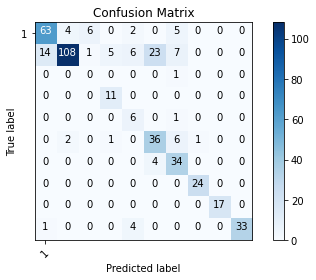

In [0]:
# rbf kernal
print(SVM_rbf)

# Linear kernel
print(SVM_linear)

# Poly kernal
print(SVM_poly)

# Singmoid kernel
print(SVM_sigmoid)

print("Akurasi SVM rbf kernel ",hasil_rbf)
print("Akurasi SVM linear kernel ",hasil_linear)
print("Akurasi SVM poly kernel ",hasil_poly)
print("Akurasi SVM sigmoid kernel ",hasil_sigmoid)

plot_confusion_matrix(confusion_poly, ['1'])

              precision    recall  f1-score   support

           1       0.91      0.91      0.91        78
           2       0.90      0.90      0.90       114
           3       0.00      0.00      0.00         7
           4       0.57      0.71      0.63        17
           5       0.92      0.67      0.77        18
           6       0.87      0.94      0.90        63
           7       0.94      0.89      0.91        54
           8       0.96      0.92      0.94        25
           9       0.92      0.71      0.80        17
          10       0.77      1.00      0.87        33

    accuracy                           0.88       426
   macro avg       0.78      0.76      0.76       426
weighted avg       0.87      0.88      0.87       426

              precision    recall  f1-score   support

           1       0.81      0.92      0.86        78
           2       0.78      0.95      0.86       114
           3       0.00      0.00      0.00         7
           4       1.00 

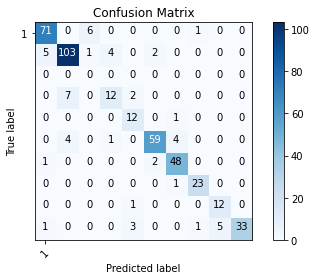

In [0]:
# Tan H
print(ANN_TanH)

# Relu
print(ANN_relu)


# Log
print(ANN_log)


# Identity
print(ANN_identity)

print("Akurasi ANN TanH",hasil_tanh)
print("Akurasi ANN Relu", hasil_relu)
print("Akurasi ANN Log", hasil_log)
print("Akurasi ANN Identity",hasil_identity)

# Evaluation Model
plot_confusion_matrix(confusion_tanh, ['1'])